In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
#from commonfunctions import *
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    # channel_count = img.shape[2]
    match_mask_color = (255)
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if(abs(y1-y2)>40): # np.sqrt(np.sum([np.square(y2-y1),np.square(x2-x1)])) #Euclidean distance
                cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def threshold(img):
    image=rgb2gray(img)
    global_thresh = threshold_otsu(image)
    binary_global = image > global_thresh
    return binary_global

def sobel_H_V_angles(img):
    # gray_img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
    blur_img = gaussian_blur(img, 9)
    sobelx = cv2.Sobel(src=blur_img, ddepth=cv2.CV_64F, dx=1, dy=0) # Sobel on the X axis
    sobelx = abs(sobelx) + 1
    sobely = cv2.Sobel(src=blur_img, ddepth=cv2.CV_64F, dx=0, dy=1) # Sobel on the Y axis
    sobely = abs(sobely) + 1
    angles = abs(sobely/sobelx) #np.arctan
    return sobelx, sobely, angles


00003.jpg


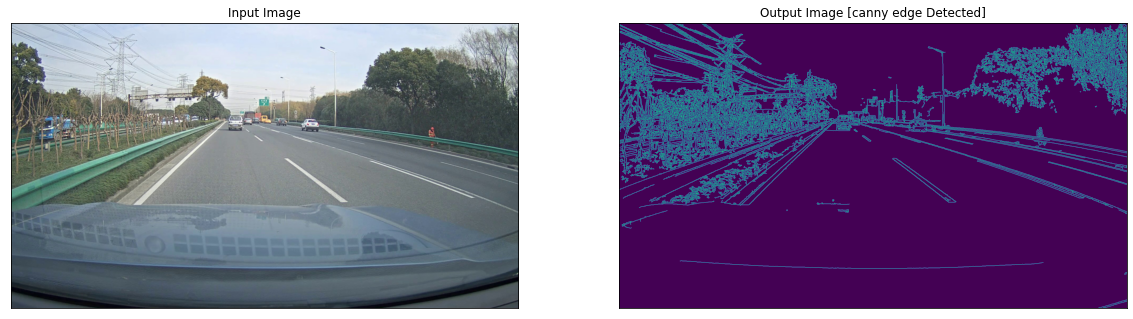

00096.jpg


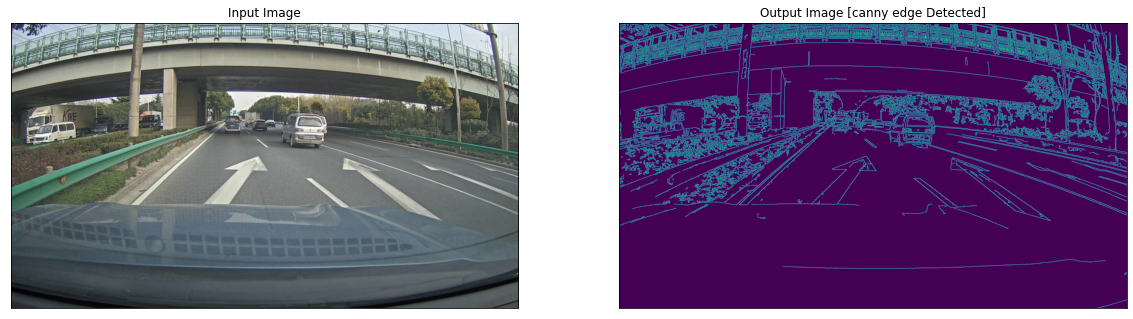

climbing-lane.jpg


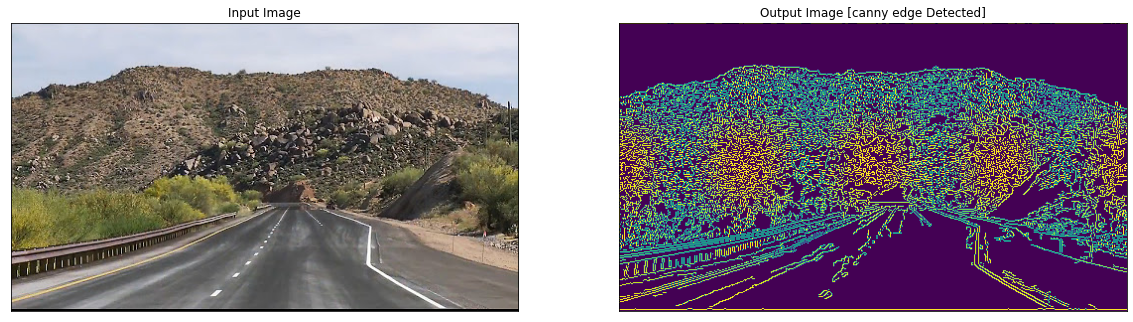

images.jfif


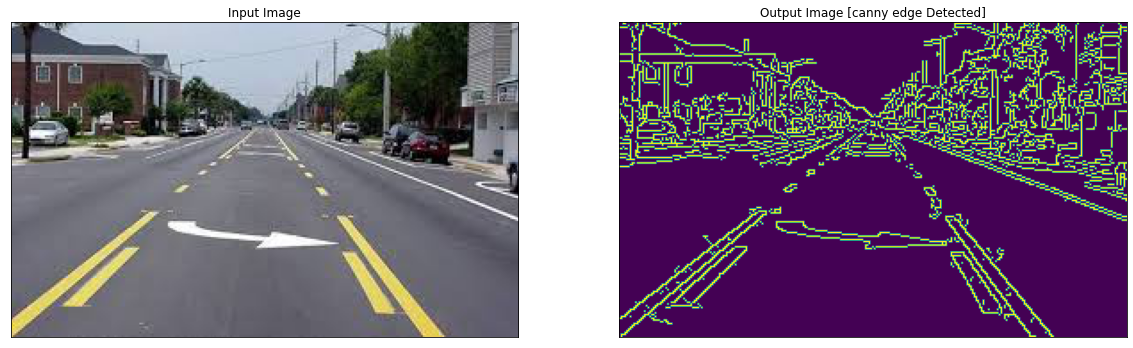

images.jpg


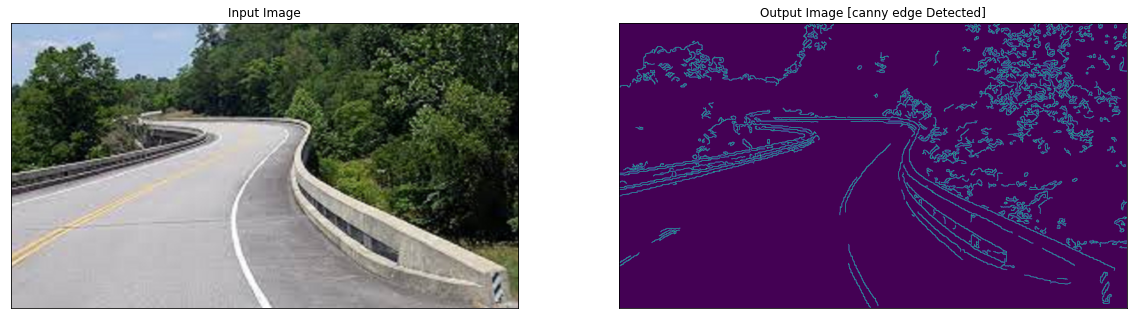

road2.jfif


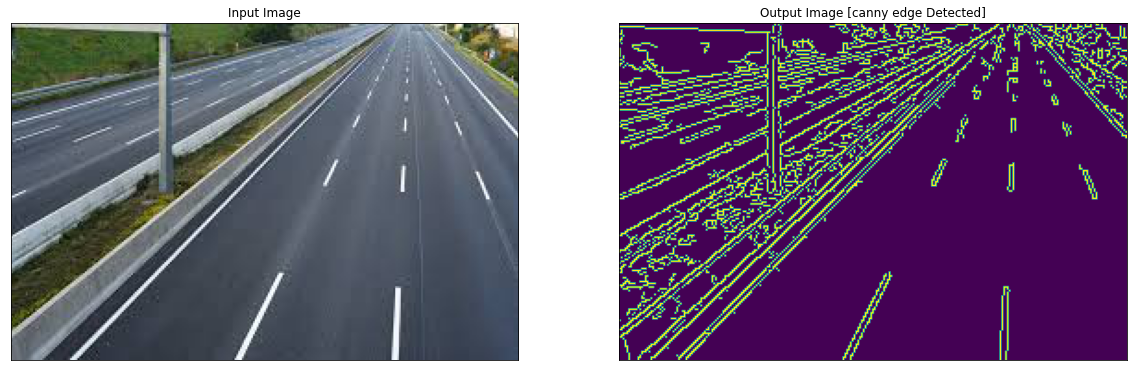

road4.jfif


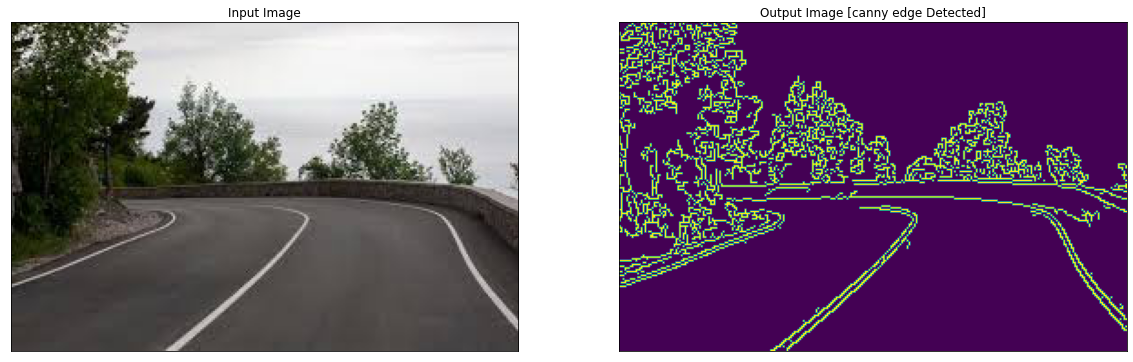

road5.jfif


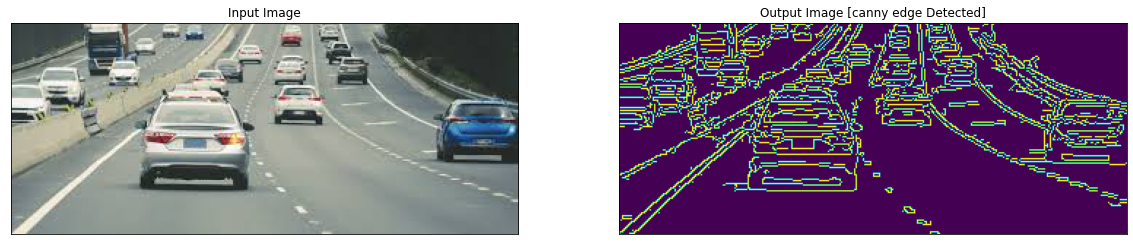

road6.jpeg


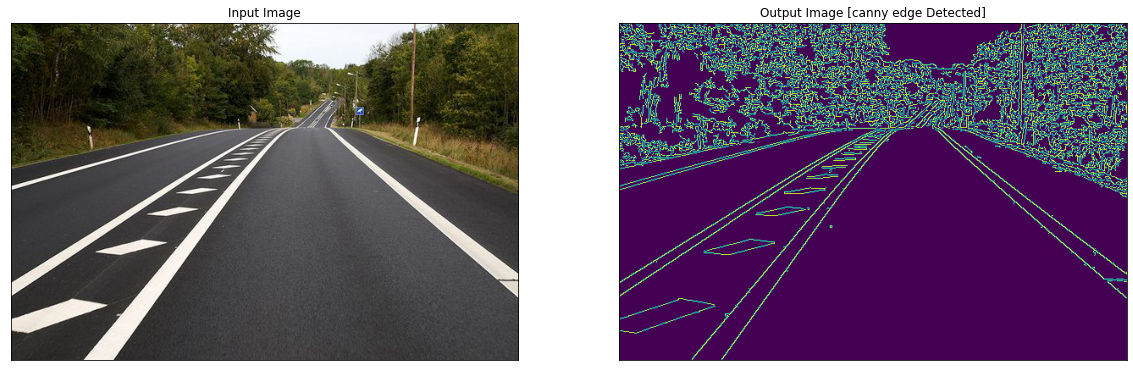

solidWhiteCurve.jpg


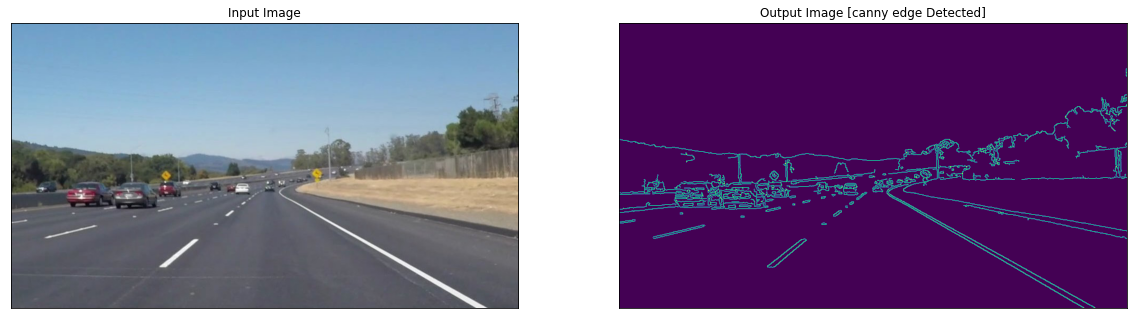

solidWhiteRight.jpg


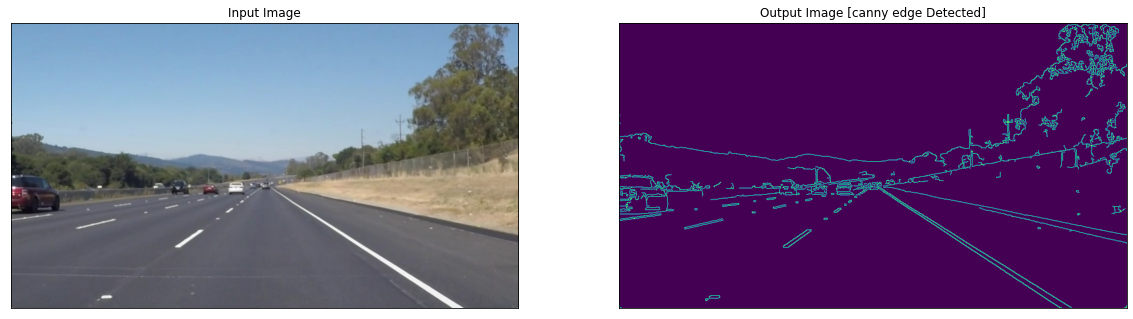

solidYellowCurve.jpg


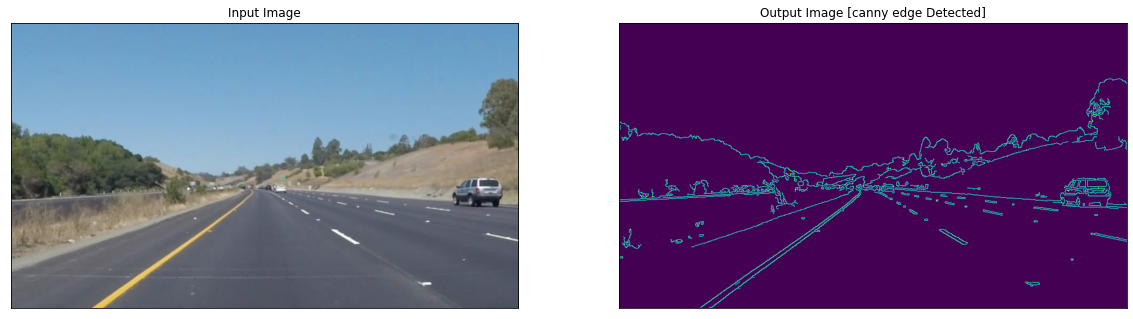

solidYellowCurve2.jpg


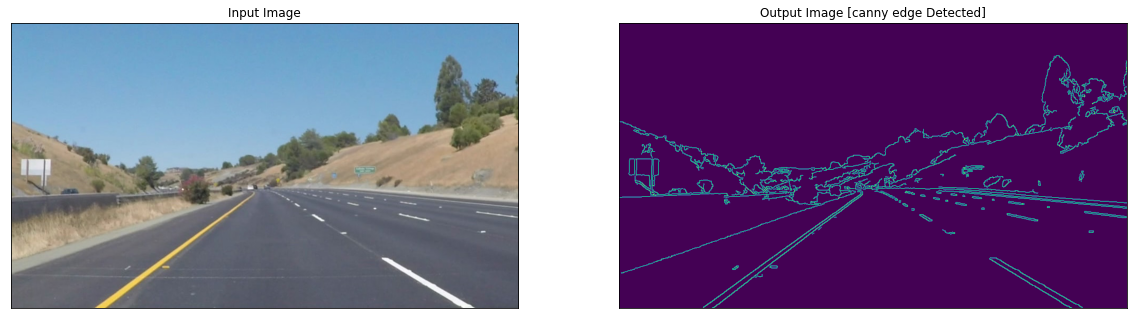

solidYellowLeft.jpg


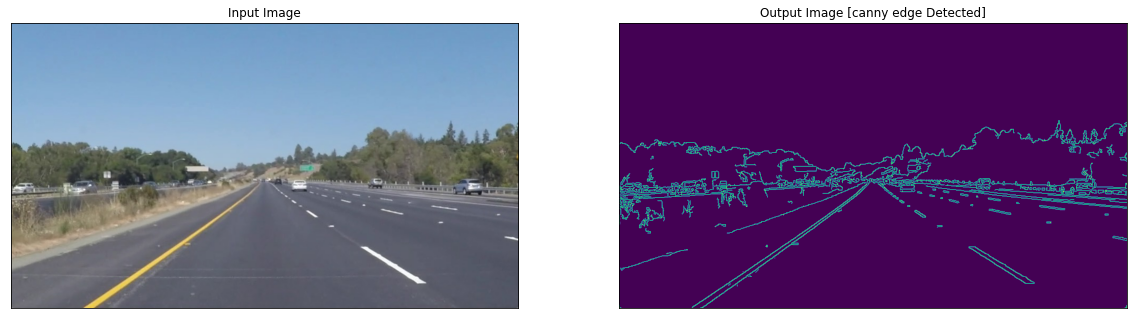

test10.jpg


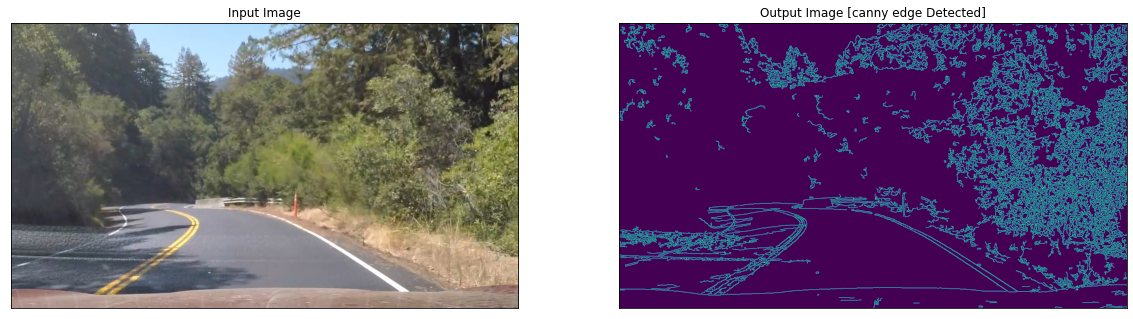

test5.jpg


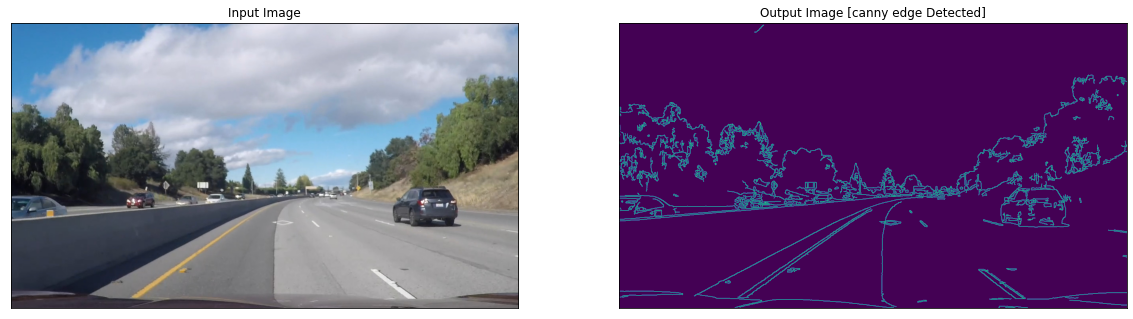

whiteCarLaneSwitch.jpg


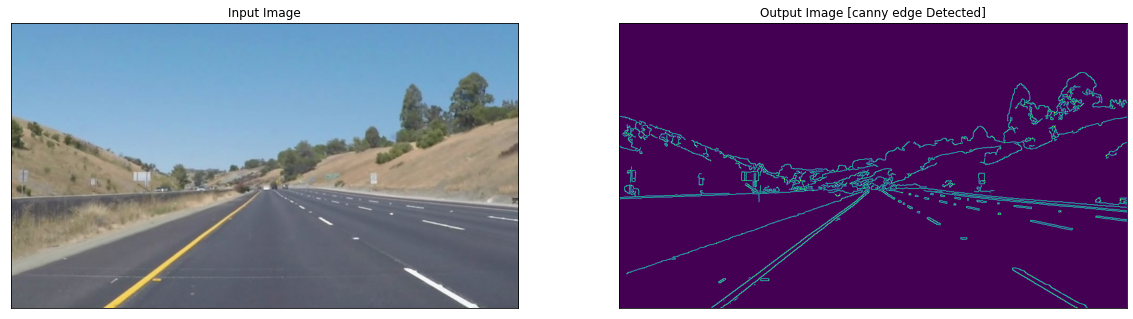

In [3]:

for image_path in list(os.listdir('./test_images')):
    print(image_path)
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(cv2.Canny(image, 50, 200))
    ax.set_title("Output Image [canny edge Detected]")
    plt.show()

In [4]:
def textur_filtring_with_angles(image, edged_img, window_height, window_width, textur_threshold):
    result = np.copy(edged_img)
    half_height = window_height//2 # Y
    half_width = window_width//2 # X
    sobelx, sobely, angles = sobel_H_V_angles(image)
    # hist_var = []
    # print(angles)
    for i in range(half_height, result.shape[0] - half_height - 10):
        for j in range(half_width, result.shape[1] - half_width):
            # mean = np.average(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            # var = np.average((angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] - mean)**2)
            min_angle = np.min(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            max_angle = np.max(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            # hist_var = hist_var + [max_angle - min_angle]
            # print(max_angle - min_angle)
            # print(var)
            if(max_angle - min_angle > textur_threshold):
                result[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] = 0
    return result

def textur_filtring_with_magnitude(image, edged_img, window_height, window_width, textur_threshold):
    result = np.copy(edged_img)
    # result = np.copy(image)
    half_height = window_height//2 # Y
    half_width = window_width//2 # X
    for i in range(half_height, result.shape[0] - half_height - 10):
        for j in range(half_width, result.shape[1] - half_width):
            if(np.sum(edged_img[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] > 0) > textur_threshold):
                result[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] = 0
    return result


00096.jpg
255
filtered_image_sum  12973
threshold  0.006256269290123457


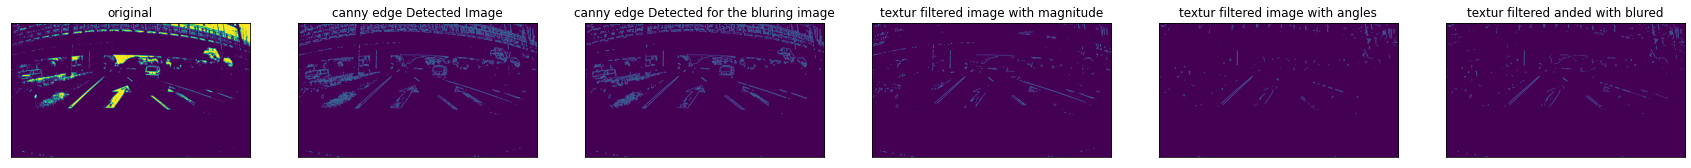

<ipython-input-13-13a6e418dfdc>:52: UserWarning: 00096.jpg is a low contrast image
  imsave(image_path,filtered_image_with_magnitude)


In [13]:
from skimage.filters import gaussian
from skimage.io import imsave, imread
count = 0
for image_path in list(os.listdir('./output')):
    count = count + 1
    fig = plt.figure(figsize=(30, 10))
    image = mpimg.imread(f'./output/{image_path}')
    print(image_path)
    ax = fig.add_subplot(1, 6, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("original")
    # blur_img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(image, 50, 200, apertureSize=3)
    ax = fig.add_subplot(1, 6, 2,xticks=[], yticks=[])
    plt.imshow(edge)
    ax.set_title("canny edge Detected Image")
    ########################################################################
    blur_img = gaussian_blur(image, 9)
    # blur_img_gray = cv2.cvtColor(blur_img, cv2.COLOR_BGR2GRAY)
    blur_edged = cv2.Canny(blur_img, 100, 200, apertureSize=3)
    ax = fig.add_subplot(1, 6, 3,xticks=[], yticks=[])
    plt.imshow(blur_edged)
    ax.set_title("canny edge Detected for the bluring image")
    ########################################################################
    ax = fig.add_subplot(1, 6, 4,xticks=[], yticks=[])
    # filtered_image_with_magnitude = textur_filtring_with_magnitude(image, edge, 20, 40, 150) #try 200 or 150
    filtered_image_with_magnitude = textur_filtring_with_magnitude(image, edge, 20, 40, 130) #try 200 or 150
    plt.imshow(filtered_image_with_magnitude)
    ax.set_title("textur filtered image with magnitude")
    ################################ Weighted sum  ########################
    print(filtered_image_with_magnitude.max())
    filtered_image_magnitude_sum = np.sum(filtered_image_with_magnitude//255)
    print("filtered_image_sum ",filtered_image_magnitude_sum)
    threshold = (filtered_image_magnitude_sum/(image.shape[0]*image.shape[1]))
    print("threshold ",threshold)
    ########################################################################
    
    ax = fig.add_subplot(1, 6, 5,xticks=[], yticks=[])
    # num_of_edges = np.sum(edge/255 != 0)
    # mean = num_of_edges / (edge.shape[0]*edge.shape[1])
    filtered_image_with_angles = textur_filtring_with_angles(image, blur_edged, 10, 10, 40) 
    plt.imshow(filtered_image_with_angles)
    ax.set_title("textur filtered image with angles")
    ########################################################################
    ax = fig.add_subplot(1, 6, 6,xticks=[], yticks=[])
    filter_and_blur = (filtered_image_with_magnitude | filtered_image_with_angles) & (filtered_image_with_angles | blur_edged) & (blur_edged | filtered_image_with_magnitude)
    plt.imshow(filter_and_blur)
    ax.set_title("textur filtered anded with blured")
    plt.show()

    # if (threshold > 0.2):
    imsave(image_path,filtered_image_with_magnitude)
        # print("anded")
    # else :
    #     imsave(image_path,filtered_image_with_magnitude)
    #     print("magnitude")
        
    # plt.figure()
    # plt.hist(var_hist, bins=range(0,len(var_hist)))
    # print(var_hist)
    

In [6]:
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges

In [7]:
def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)

In [8]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img


In [9]:
def draw_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
           
            # result = np.sqrt((y2-y1)**2 + (x2-x1)**2)
            if(abs(y2-y1) > 20):
               cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img


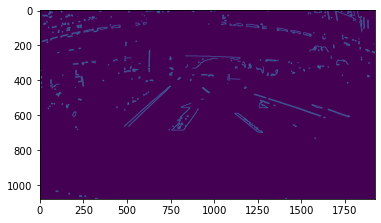

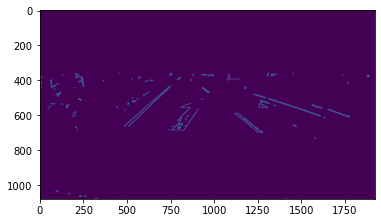

In [10]:
import skimage.io as io
import matplotlib.pyplot as plt

image1 = io.imread("00096.jpg")
image = np.copy(image1)
plt.imshow(image1)
plt.show()

image_cropped_lower = image[int(image.shape[0]/3):]

image[:int(image.shape[0]/3)] = 0
image_cropped_upper = image[:int(image.shape[0]/3)]

thresholded = np.block([[image_cropped_upper],[image_cropped_lower]])

plt.imshow(thresholded)
plt.show()

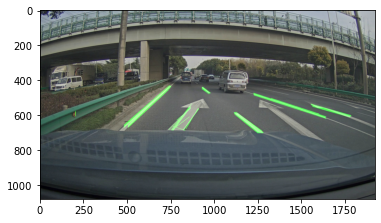

In [11]:

    image = mpimg.imread("test_images/00096.jpg")
    # filter_and_blur = mpimg.imread("output/test_output/images.jpg")
    # plt.imshow(filter_and_blur)
    # plt.show()
    output = np.copy(image)
    # houghed_lines = hough_lines(img = filter_and_blur, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    houghed_lines = cv2.HoughLinesP(thresholded, rho=2, theta=np.pi/180,
                           threshold=120, lines=np.array([]), minLineLength=10, maxLineGap=30)
    output = draw_lines(image, houghed_lines)
    # #Draw lines on edges
    # output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    # Color pixels red where both color and region selections met
    # print(image.shape[0])
    # print(image.shape[1])
    # # output[filter_and_blur] = [9, 255, 0]  
    # for i in range (3,image.shape[0]-3):
    #      for j in range (0,image.shape[1]):
    #          if(filter_and_blur[i][j]==1):
    #              output[i-3][j] = [9, 255, 0]  
    #              output[i-2][j] = [9, 255, 0]  
    #              output[i-1][j] = [9, 255, 0]  
    #              output[i][j]   = [9, 255, 0]  
    #              output[i+1][j] = [9, 255, 0]  
    #              output[i+2][j] = [9, 255, 0]  
    #              output[i+3][j] = [9, 255, 0]  
       
    plt.imshow(output)

    # # fig = plt.figure(figsize=(30, 10))
    # # ax = fig.add_subplot(1, 3, 1,xticks=[], yticks=[])
    # # plt.imshow(image)
    # # ax.set_title("original")
    # # plt.show()

    # # ax = fig.add_subplot(1, 3, 2,xticks=[], yticks=[])
    # # plt.imshow(filter_and_blur)
    # ax.set_title("filter")
    # plt.show()

    # ax = fig.add_subplot(1, 3, 3,xticks=[], yticks=[])
    # plt.imshow(output)
    # ax.set_title("output")
    # plt.show()

NameError: name 'textur_filtring' is not defined

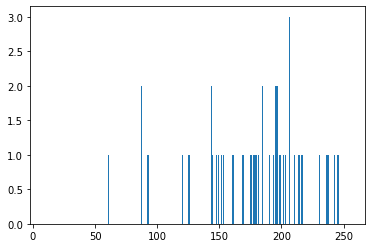

<Figure size 432x288 with 0 Axes>

In [12]:
from skimage.exposurtextur_filtringe import histogram
from matplotlib.pyplot import bar
any_image = mpimg.imread(f'./test_images/images.jfif')
edge = cv2.Canny(any_image, 50, 200, apertureSize=3)
imgHist = np.zeros(256)
half_height = 20
half_width = 40
for i in range(half_height, edge.shape[0] - half_height):
    for j in range(half_width, edge.shape[1] - half_width):
        mean = np.average(edge[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
        imgHist[mean.astype(np.uint8)] = imgHist[mean.astype(np.uint8)] + 1

# num_of_edges = np.sum(edge != 0)
# mean = num_of_edges / (edge.shape[0]*edge.shape[1])
# print(num_of_edges)
# print(mean)
imgHist[0] = 0
plt.hist(imgHist[0:255], bins=range(10,(2 ** 8)))
plt.figure()
filtered_image = textur_filtring(any_image, edge, 20, 40, 140)
io.imshow(filtered_image)
io.show()

